# **Twitter Sentiment Analysis**

![twitter](https://www.aimtechnologies.co/wp-content/uploads/2024/01/Twitter-Sentiment-Analysis.png)

# **Building a model with Word2vec**

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

In [ ]:
import re
import pandas as pd
import numpy as np

from gensim.models import KeyedVectors
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score

### **EDA**

In [ ]:
model_name = 'CNN+LSTM'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
add = '/content/drive/MyDrive/Lstm-CNN project/clean_datasets/com-semeval-com'
col = 'clean-text'
target = 'label'

In [ ]:
df = pd.read_csv(add, engine='python')
df = df[df[target]!='litigious']
df.head()

,label,text
0,neutral,Watching Devil Inside for the 1st time tonight...
1,neutral,"Devil Inside , The exorcisism of Emily Rose , ..."
2,neutral,Off to do my vlog. Watching Devil Inside and J...
3,positive,take Silver at the Hib cup. Great day. See you...
4,neutral,I'm going to blockbuster tomorrow to get Devil...


In [ ]:
dic = {"positive":"positive", "uncertainty":"neutral", "negative":"negative"}
df.replace({target: dic}, inplace=True)

In [ ]:
possible_labels = df[target].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df['label'] = df[target].replace(label_dict)

/tmp/ipython-input-3913799863.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df[target].replace(label_dict)


In [ ]:
lb = label_dict.keys()

In [ ]:
lb

dict_keys(['neutral', 'positive', 'negative'])

In [ ]:
col = 'text'
df = df[['label', col]]
df.columns = ['label', 'note']


In [ ]:
print(df.columns)
print(col)


Index(['label', 'note'], dtype='object')
text


In [ ]:
df['len'] = df.note.str.len()
df['word_counts'] = df.note.str.split().str.len()
df.head()

,label,note,len,word_counts
0,0,Watching Devil Inside for the 1st time tonight...,61,10
1,0,"Devil Inside , The exorcisism of Emily Rose , ...",101,21
2,0,Off to do my vlog. Watching Devil Inside and J...,86,14
3,1,take Silver at the Hib cup. Great day. See you...,83,16
4,0,I'm going to blockbuster tomorrow to get Devil...,70,12


In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
output = df.label.nunique()

### **Modeling**

In [ ]:
results = []
df3 = pd.DataFrame({})
df3.to_csv('/content/drive/MyDrive//Lstm-CNN project/clean_datasets/res.csv')
result = pd.read_csv('/content/drive/MyDrive//Lstm-CNN project/clean_datasets/res.csv')

def plot_graphs(history, string):
    eps = len(history.history['loss'])
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.plot(range(1, eps+1), history.history[string])
    plt.plot(range(1, eps+1), history.history['val_'+string])
    plt.xticks(range(1, eps+1))
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig("/content/drive/MyDrive/Lstm-CNN project/plots/"+string+".png", bbox_inches='tight', dpi=500)
    plt.show()

def plot_diagram(cnf_matrix, name):
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cnf_matrix, columns=lb,
                             index=lb),
                annot=True,
                cmap="YlGnBu",
                fmt='g')
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/Lstm-CNN project/result/heatmap-'+name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

def show_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))

def plot_diagram2(y, pred, name):

    idx = len(result)

    acc = np.round(metrics.accuracy_score(y, pred), 3)
    rec = np.round(metrics.recall_score(y, pred, average='weighted'), 3)
    prec= np.round(metrics.precision_score(y, pred, average='weighted'), 3)
    f1= np.round(metrics.f1_score(y, pred, average='weighted'), 3)

    result.at[idx, 'name'] = name
    result.at[idx, 'accuracy'] = acc
    result.at[idx, 'recall'] = rec
    result.at[idx, 'precison'] = prec
    result.at[idx, 'f1'] = f1

    clf_report = classification_report(y,
                                       pred,
                                       target_names=lb,
                                       output_dict=True)
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
    plt.savefig('/content/drive/MyDrive/Lstm-CNN project/result/'+name+'.png', dpi=300, bbox_inches='tight')

def calc_roc(name, y_pred, y_test):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    results.append([fpr, tpr, name + ", AUC={:.3f}".format(auc)])

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz


--2025-08-12 22:40:17--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  62.3MB/s    in 21s     

2025-08-12 22:40:38 (59.3 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
file_path = 'cc.en.300.vec'

In [ ]:
file_address = file_path

ft_model = KeyedVectors.load_word2vec_format(file_address,
                                             limit=300000)

ft_words = []
words = list(ft_model.index_to_key)
for ft_word in words:
    ft_words.append(ft_word)

embedding_list = list()
for w in ft_words:
    embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

all_embedding.shape

(300000, 300)

In [ ]:
dummy_category = pd.get_dummies(df.label)

In [ ]:
max_features = 7000
maxlen = 100
embedding_dim = 300

In [ ]:
epochs = 20
batch_size = 8

In [ ]:
tok = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tok.fit_on_texts(list(df[:].note))
vocab_size = len(tok.word_index)+1
train_df = tok.texts_to_sequences(list(df.note))
train_df = tf.keras.preprocessing.sequence.pad_sequences(train_df, maxlen=maxlen)

In [ ]:
nb_words = len(tok.word_index) + 1

embedding_matrix = np.random.normal(emb_mean,
                                    emb_std,
                                    (nb_words, embedding_dim))

embeddedCount = 0
for word, i in tqdm(tok.word_index.items()):
    i -= 1
    if word in words:
        embedding_vector = ft_model[word]
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:
        embedding_vector = np.zeros(embedding_dim)
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

100%|██████████| 52273/52273 [02:27<00:00, 353.89it/s]

total embedded: 52273 common words
Embedding matrix shape: (52274, 300)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, df[target], test_size=0.15, random_state=42, stratify=df[target]
)


y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

y_train.columns = y_test.columns = ['positive', 'neutral', 'negative']

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=nb_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))


model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001) , metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    15,682,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,682,200 (59.82 MB)

 Trainable params: 15,682,200 (59.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_split=0.15,
                    callbacks=[callback],
                    epochs=epochs, batch_size=batch_size)

Epoch 1/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 269s 20ms/step - accuracy: 0.5575 - loss: 0.9043 - val_accuracy: 0.6904 - val_loss: 0.6956
Epoch 2/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 305s 20ms/step - accuracy: 0.7211 - loss: 0.6453 - val_accuracy: 0.7216 - val_loss: 0.6456
Epoch 3/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 266s 20ms/step - accuracy: 0.7708 - loss: 0.5534 - val_accuracy: 0.7353 - val_loss: 0.6523
Epoch 4/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 270s 20ms/step - accuracy: 0.8434 - loss: 0.4079 - val_accuracy: 0.8116 - val_loss: 0.5046
Epoch 5/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 262s 21ms/step - accuracy: 0.9164 - loss: 0.2434 - val_accuracy: 0.8559 - val_loss: 0.4632
Epoch 6/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 249s 20ms/step - accuracy: 0.9548 - loss: 0.1377 - val_accuracy: 0.8773 - val_loss: 0.4524
Epoch 7/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 265s 20ms/step - accuracy: 0.9741 - loss: 0.0857 - val_accuracy: 0.8895 - val_loss: 0.4692
Epoch 8/20
12637/12637 ━━━━━━━━━━━━━━━━━━━━ 268s 20ms/s

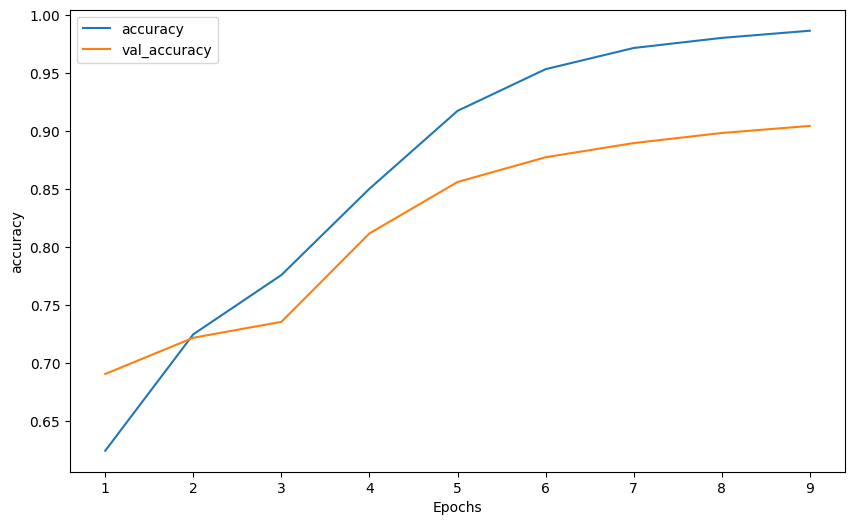

In [ ]:
plot_graphs(history, "accuracy")

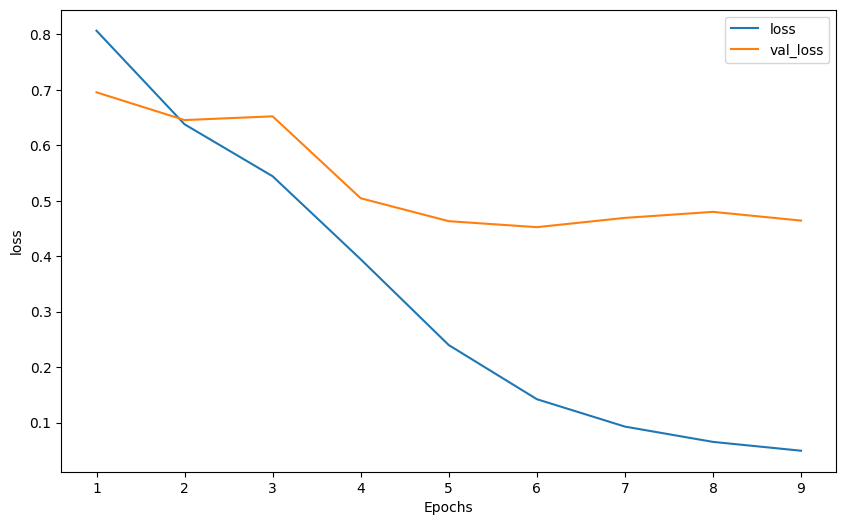

In [ ]:
plot_graphs(history, "loss")

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(np.array(y_test), axis=1)

2624/2624 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


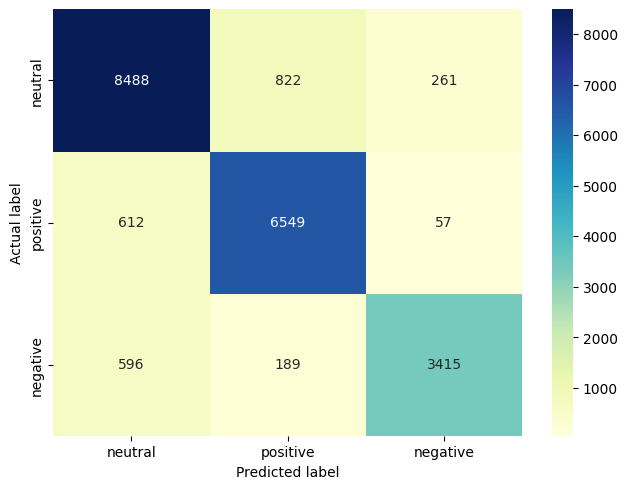

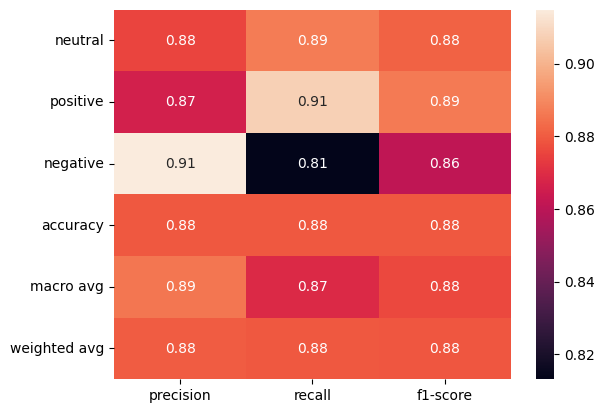

In [ ]:
conf = confusion_matrix(y_test2, y_pred_bool)
plot_diagram(conf, model_name)
plot_diagram2(y_test2, y_pred_bool, model_name)

In [ ]:
result.to_csv('res.csv', index=False)

# **Building a model with BERT**

In [ ]:
!pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.0.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score,recall_score,precision_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import os

### **EDA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
m_name = 'bert-base-uncased'
batch_size = 32
epochs = 6

In [ ]:
max_length=100

In [ ]:
add = '/content/drive/MyDrive/Lstm-CNN project/clean_datasets/com-semeval-com'
col = 'text'
target = 'label'

In [ ]:
df = pd.read_csv(add, engine='python')
df = df[df[target]!='litigious']
df.head()

,label,text
0,neutral,Watching Devil Inside for the 1st time tonight...
1,neutral,"Devil Inside , The exorcisism of Emily Rose , ..."
2,neutral,Off to do my vlog. Watching Devil Inside and J...
3,positive,take Silver at the Hib cup. Great day. See you...
4,neutral,I'm going to blockbuster tomorrow to get Devil...


In [ ]:
df = df[[target, col]]
df.columns = ['recom', 'comment']

In [ ]:
df.recom.value_counts()

,count
recom,
neutral,63807
positive,48119
negative,27997


In [ ]:
df.dropna(subset=['recom', 'comment'], inplace=True, how="any")
df.reset_index(drop=True, inplace=True)

In [ ]:
possible_labels = df.recom.unique()
possible_labels

array(['neutral', 'positive', 'negative'], dtype=object)

In [ ]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'neutral': 0, 'positive': 1, 'negative': 2}

In [ ]:
lb = df.recom.unique()
lb

array(['neutral', 'positive', 'negative'], dtype=object)

In [ ]:
df['label'] = df.recom.replace(label_dict)

/tmp/ipython-input-2792344512.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.recom.replace(label_dict)


In [ ]:
df.head()

,recom,comment,label
0,neutral,Watching Devil Inside for the 1st time tonight...,0
1,neutral,"Devil Inside , The exorcisism of Emily Rose , ...",0
2,neutral,Off to do my vlog. Watching Devil Inside and J...,0
3,positive,take Silver at the Hib cup. Great day. See you...,1
4,neutral,I'm going to blockbuster tomorrow to get Devil...,0


### **Training/Validation Split**

<Axes: >

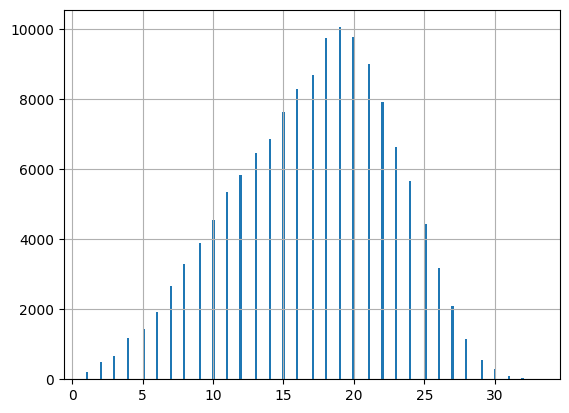

In [ ]:
df['len'] = df.comment.str.split().str.len()
df['len'].hist(bins=200)

In [ ]:
def plot_graphs(history, string):
    eps = len(history['loss'])
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.plot(range(1, eps+1), history[string])
    plt.plot(range(1, eps+1), history['val_'+string])
    plt.xticks(range(1, eps+1))
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(os.path.join(plot_dir, f"{string}_bert.png"), bbox_inches='tight', dpi=500)
    plt.show()

def plot_diagram(cnf_matrix, name):
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cnf_matrix, columns=lb, index=lb),
                annot=True, cmap="YlGnBu", fmt='g')
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(result_dir, f"heatmap-{name}_bert.png"), dpi=600, bbox_inches='tight')
    plt.show()

def show_result(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")

def plot_diagram2(y, pred, name):
    global result
    idx = len(result)

    acc = np.round(accuracy_score(y, pred), 3)
    rec = np.round(recall_score(y, pred, average='weighted'), 3)
    prec = np.round(precision_score(y, pred, average='weighted'), 3)
    f1 = np.round(f1_score(y, pred, average='weighted'), 3)

    result.at[idx, 'name'] = name
    result.at[idx, 'accuracy'] = acc
    result.at[idx, 'recall'] = rec
    result.at[idx, 'precison'] = prec
    result.at[idx, 'f1'] = f1
    result.to_csv(result_path, index=False)

    clf_report = classification_report(y, pred, target_names=lb, output_dict=True)
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
    plt.savefig(os.path.join(result_dir, f"{name}_bert.png"), dpi=600, bbox_inches='tight')
    plt.show()

def calc_roc(name, y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred)
    results.append([fpr, tpr, f"{name}, AUC={auc:.3f}"])

In [ ]:
def Percentage_of_classes(y_true):
  pc=(len(y_true)/len(df))* 100
  return round(pc,2)

In [ ]:
result_path = '/content/drive/MyDrive/Lstm-CNN project/clean_datasets/res.csv'
plot_dir = '/content/drive/MyDrive/Lstm-CNN project/plots_bert/'
result_dir = '/content/drive/MyDrive/Lstm-CNN project/result_bert'
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

results = []
df3 = pd.DataFrame({})
df3.to_csv(result_path)
result = pd.read_csv(result_path)

In [ ]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

In [ ]:
tokenizer = BertTokenizer.from_pretrained(m_name,
                                          do_lower_case=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data = tokenizer(
    df['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['label'].values)

In [ ]:
train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(
    input_ids, labels, test_size=0.3, random_state=42
)
train_masks, temp_masks = train_test_split(
    attention_masks, test_size=0.3, random_state=42
)

val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    temp_inputs, temp_labels, test_size=0.5, random_state=42
)
val_masks, test_masks = train_test_split(
    temp_masks, test_size=0.5, random_state=42
)

In [ ]:
print(f"Train set: {Percentage_of_classes(train_labels)} Percentage of samples")
print(f"Validation set: {Percentage_of_classes(val_labels)} Percentage of samples")
print(f"Test set: {Percentage_of_classes(test_labels)} Percentage of samples")

Train set: 70.0 Percentage of samples
Validation set: 15.0 Percentage of samples
Test set: 15.0 Percentage of samples


In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
class BertCnnLstmClassifier(nn.Module):
    def __init__(self, bert_model_name, num_labels, cnn_filters=64, lstm_hidden=128, dropout=0.3):
        super(BertCnnLstmClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.cnn = nn.Conv1d(in_channels=768, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=cnn_filters, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, num_labels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]

        sequence_output = sequence_output.permute(0, 2, 1)
        cnn_out = self.cnn(sequence_output)
        cnn_out = self.relu(cnn_out)

        cnn_out = cnn_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_out)
        logits = self.fc(out)
        return logits

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BertCnnLstmClassifier(m_name, num_labels=3).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_preds, train_labels_list = [], []
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        logits = model(b_input_ids, b_attention_mask)
        loss = criterion(logits, b_labels)
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(b_labels.cpu().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = accuracy_score(train_labels_list, train_preds)
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(train_accuracy)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")

    model.eval()
    val_loss = 0
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
            logits = model(b_input_ids, b_attention_mask)
            loss = criterion(logits, b_labels)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(b_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}, F1-Score: {f1_score(val_labels_list, val_preds, average='weighted'):.3f}")

Epoch 1:   0%|          | 0/3061 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.701, Training Accuracy: 0.694
Validation Loss: 0.578, Validation Accuracy: 0.758, F1-Score: 0.758


Epoch 2:   0%|          | 0/3061 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.443, Training Accuracy: 0.830
Validation Loss: 0.456, Validation Accuracy: 0.831, F1-Score: 0.831


Epoch 3:   0%|          | 0/3061 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.260, Training Accuracy: 0.912
Validation Loss: 0.407, Validation Accuracy: 0.867, F1-Score: 0.867


Epoch 4:   0%|          | 0/3061 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.171, Training Accuracy: 0.946
Validation Loss: 0.397, Validation Accuracy: 0.885, F1-Score: 0.885


Epoch 5:   0%|          | 0/3061 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.124, Training Accuracy: 0.963
Validation Loss: 0.392, Validation Accuracy: 0.895, F1-Score: 0.895


Epoch 6:   0%|          | 0/3061 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.097, Training Accuracy: 0.972
Validation Loss: 0.402, Validation Accuracy: 0.899, F1-Score: 0.898


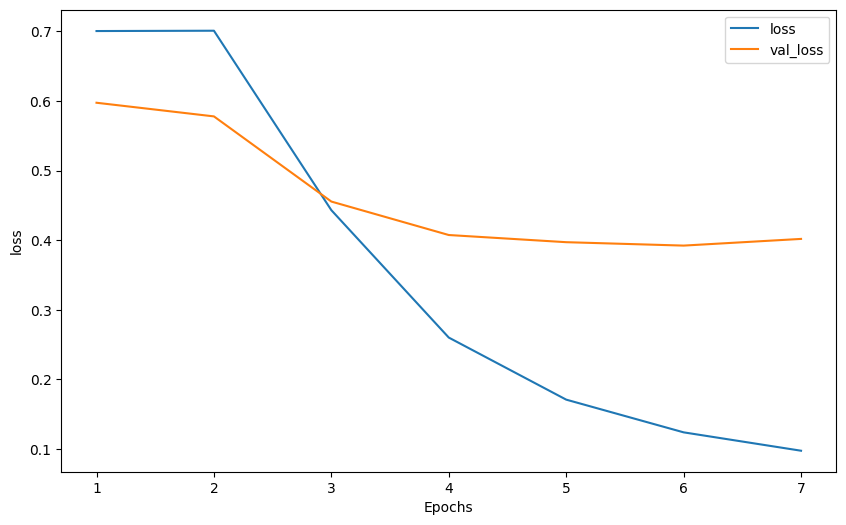

In [ ]:
plot_graphs(history, 'loss')

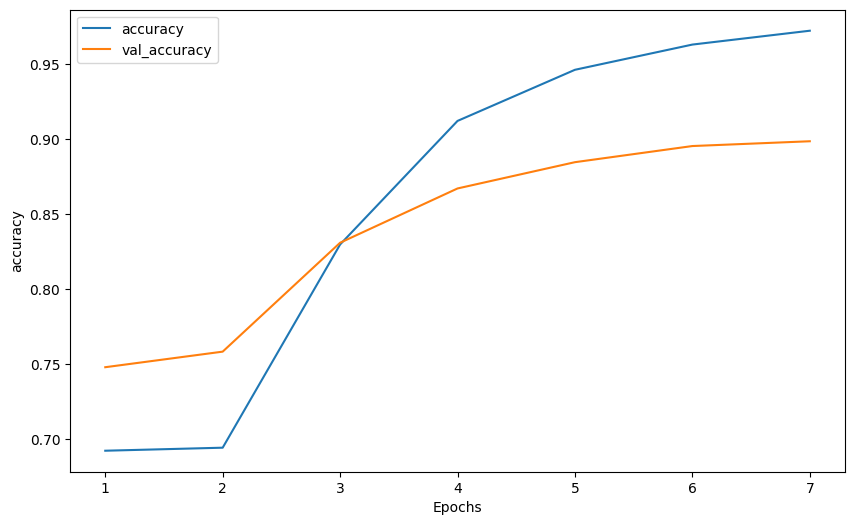

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
model.eval()
test_preds, test_labels_list = [], []
test_probs = []
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
        logits = model(b_input_ids, b_attention_mask)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(b_labels.cpu().numpy())
        test_probs.extend(probs)

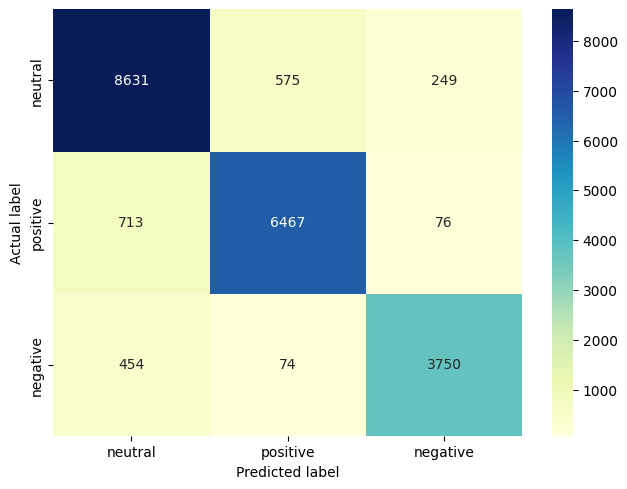

In [ ]:
plot_diagram(confusion_matrix(test_labels_list, test_preds), 'bert_cnn_lstm')

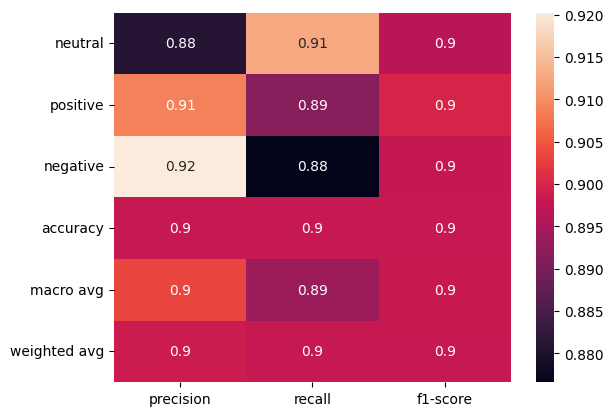

In [ ]:
plot_diagram2(test_labels_list, test_preds, 'bert_cnn_lstm')